In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import Image, display
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
tf.__version__

'1.13.1'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 24
num_epochs = 100
val_steps = 20
MODEL_NAME = 'nasnetmobile'

In [5]:
image_csv = pd.read_csv('./../data/all.csv')

# Prepend image filenames in train/ with relative path
filenames = image_csv['path'].tolist()
labels = image_csv['label'].tolist()

train_filenames, val_filenames, train_labels, val_labels = train_test_split(filenames,
                                                                            labels,
                                                                            train_size=0.8,
                                                                            random_state=420)

num_train = len(train_filenames)
num_val = len(val_filenames)
output_size = len(set(train_labels + val_labels))

In [6]:
def _parse_fn(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string)
    image_normalized = (tf.cast(image_decoded, tf.float32)/127.5) - 1
    image_resized = tf.image.resize(image_normalized, (IMAGE_SIZE, IMAGE_SIZE))
    return image_resized, label

In [7]:
train_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_filenames), tf.constant(train_labels))).map(_parse_fn).shuffle(buffer_size=10000).batch(BATCH_SIZE)


val_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_filenames), tf.constant(val_labels))).map(_parse_fn).batch(BATCH_SIZE)


In [8]:
# Base model with Xception
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

model = tf.keras.applications.nasnet.NASNetMobile(input_shape=IMG_SHAPE, 
                                       classes=output_size,
                                       weights=None)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('./models/weights_%s_%s.h5' % (MODEL_NAME, IMAGE_SIZE), monitor='val_acc', 
                     mode='max', verbose=0, save_best_only=True)
csv_logger = CSVLogger('logs/%s.log' % MODEL_NAME)

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss='categorical_crossentropy',
             metrics=['acc'])

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalizationV1) (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
__________________________________________________________________________________________________
reduction_

In [11]:
steps_per_epoch = round(num_train)//BATCH_SIZE

In [12]:
history = model.fit(train_data.repeat(),
                    epochs=num_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data=val_data.repeat(), 
                    validation_steps=val_steps,
                    callbacks=[es, mc, csv_logger],
                    workers=8,
                    use_multiprocessing=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
697/697 [==============================] - 453s 650ms/step - loss: 2856.2805 - acc: 0.0227 - val_loss: 2732.5134 - val_acc: 0.0000e+00
Epoch 2/100
697/697 [==============================] - 216s 311ms/step - loss: 2852.7923 - acc: 0.0234 - val_loss: 3041.9063 - val_acc: 0.0000e+00
Epoch 3/100
697/697 [==============================] - 217s 311ms/step - loss: 2853.0777 - acc: 0.0284 - val_loss: 2975.5102 - val_acc: 0.0000e+00
Epoch 4/100
697/697 [==============================] - 217s 311ms/step - loss: 2852.1211 - acc: 0.0356 - val_loss: 3018.5158 - val_acc: 0.0000e+00
Epoch 5/100
697/697 [==============================] - 217s 311ms/step - loss: 2855.0918 - acc: 0.0062 - val_loss: 2873.8559 - val_acc: 0.0000e+00
Epoch 6/100
697/697 [==============================] - 216s 310ms/step - loss: 2850.6339 - acc: 0.0148 - val_loss: 2860.5523 - val_acc: 0.0000e+00
Epoch 7/100
697/697 [==============================] - 216s 311ms/step

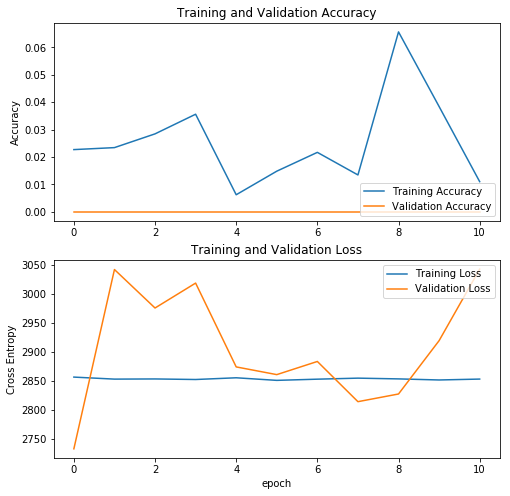

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
